In [414]:
import os
import random
import sys
import subprocess
from operator import itemgetter

import re
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import gensim

In [431]:
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.mlab as mlab
%matplotlib inline

sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

## Word analysis with Old English poetry corpus
This notebook works with the Old English poetry corpus made publicly available by  Murray McGillivray at the University of Calgary (http://people.ucalgary.ca/~mmcgilli/OEPoetry/)

* basic word analyses
* simple embeddings
* phonological distance for comparing words

### Read in Old English poetry corpus 

In [3]:
# read in all the poems 
path = '/Users/ChadMorgan/Documents/old_english/OldEnglishPoetryCorpus/scraped_corpus'
contents = os.listdir(path)

In [406]:
print("Number of OE poems in corpus:",len(contents))

Number of OE poems: 348


In [457]:
corpus_lines = []
token_set = set()
token_dict = {}
poem_line_ct = []
for poem in contents:
    poem_lines = open(path+'/'+poem).readlines()
    poem_line_ct += [(poem,len(poem_lines))]
    for line in poem_lines:
        # remove punctuation and extra whitespace
        line = re.sub("\.|\:|\!|\,|\n|\;",'',line)
        line = re.sub("$ | ^",'',line)
        line_tokens = line.split(' ')
        line_tokens_clean = []
        for l in line_tokens:
            if l != '':
                # use of q is only in latin loanwords. 
                # xx should only occur in roman numerals
                if re.search('q',l) or re.search('xx',l):
                    continue
                # valid words must contain a vowel
                elif re.search("['y','i','u','e','o','æ','a']",l):
                    line_tokens_clean += [l]
                    if l not in token_set:
                        token_dict[l] = 1
                        token_set.add(l)
                    else:
                        token_dict[l] += 1
        if len(line_tokens_clean)>0:
            corpus_lines += [line_tokens_clean]
flat_tokens = [item for sublist in corpus_lines for item in sublist]            

In [458]:
print("total lines:",len(corpus_lines))
print("total words:",len(flat_tokens))
print("unique words:",len(set(tokens)))
print("\nTop poems by lines:")
sorted(poem_line_ct,key=itemgetter(1),reverse=True)[0:10]

total lines: 30497
total words: 175014
unique words: 26994

Top poems by lines:


[('beowulf.txt', 3240),
 ('genesis.txt', 2941),
 ('andreas.txt', 2067),
 ('christ_a_b_c.txt', 1997),
 ('guthlac_a_b.txt', 1655),
 ('elene.txt', 1587),
 ('daniel.txt', 917),
 ('juliana.txt', 879),
 ('christ_and_satan.txt', 877),
 ('the_phoenix.txt', 813)]

## Simple word analyses

### Most common words

In [427]:
token_count = pd.DataFrame.from_dict(token_dict,orient='index').reset_index()
token_count.columns = ['token','freq']
token_count = token_count.sort_values('freq',ascending=False)\
    .reset_index(drop=True)
print("Top words by frequency:")
print(token_count.head(10))

token_count = token_count.reset_index()

Top words by frequency:
  token  freq
0    on  4379
1   and  3177
2   þæt  2912
3    þa  2166
4    ic  2090
5   ond  2055
6    he  1943
7    þe  1930
8    ne  1868
9    to  1813


### Rank vs. frequency of word (Zipf's law)

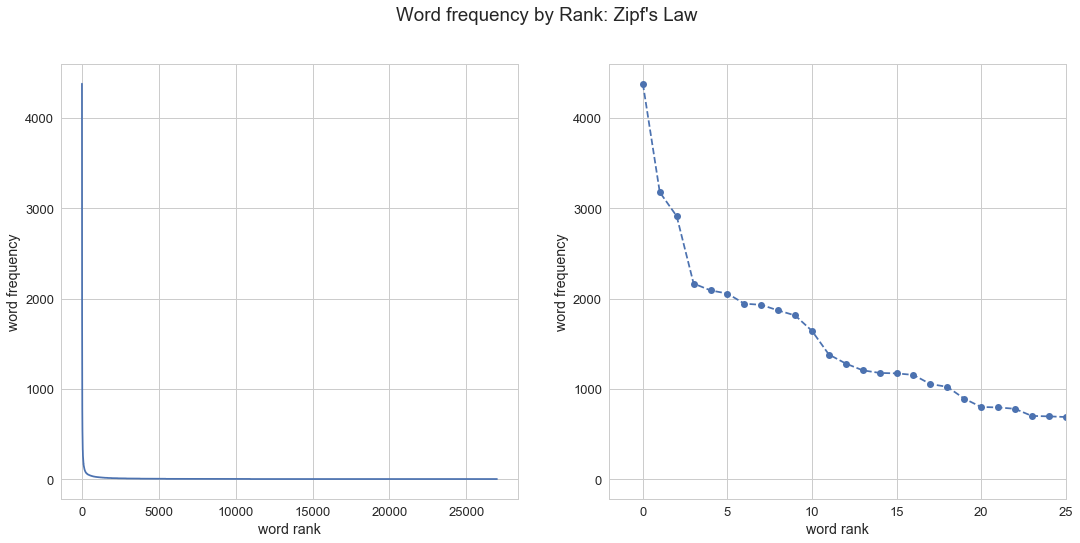

In [434]:
plt.figure(figsize=(18, 8))
plt.suptitle("Word frequency by Rank: Zipf's Law")
plt.subplot(121)
plt.plot(token_count['index'],token_count['freq'])
plt.xlabel('word rank')
plt.ylabel('word frequency')
plt.subplot(122)
plt.plot(token_count['index'],token_count['freq'],linestyle='--', marker='o')
plt.xlim([-2,25])
plt.xlabel('word rank')
plt.ylabel('word frequency')

### Word lengths

count    26994.000000
mean         7.245166
std          2.239697
min          1.000000
25%          6.000000
50%          7.000000
75%          9.000000
max         19.000000
Name: token_len, dtype: float64


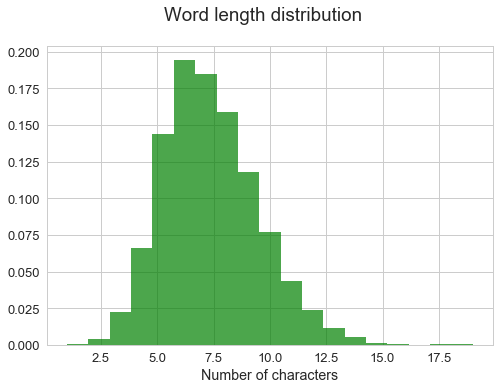

In [440]:
token_count['token_len'] = token_count['token'].apply(lambda x: len(x))
print(token_count['token_len'].describe())
n, bins, patches = plt.hist(token_count['token_len'], 19, normed=1, facecolor='green', alpha=0.7)
plt.suptitle('Word length distribution')
plt.xlabel('Number of characters')

[6, 4, 6, 5, 6]


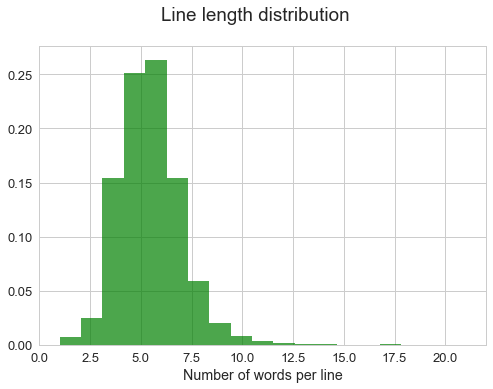

In [459]:
line_length = []
for l in corpus_lines:
    line_length += [len(l)]
print(line_length[0:5])

n, bins, patches = plt.hist(line_length, 19, normed=1, facecolor='green', alpha=0.7)
plt.suptitle('Line length distribution')
plt.xlabel('Number of words per line')

## Word2Vec with raw words

In [464]:
print(corpus_lines[0:5])

[['æla', 'drihten', 'leof', 'æla', 'dema', 'god'], ['geara', 'me', 'ece', 'waldend'], ['ic', 'wat', 'mine', 'saule', 'synnum', 'forwundod'], ['gehæl', 'þu', 'hy', 'heofena', 'drihten'], ['and', 'gelacna', 'þu', 'hy', 'lifes', 'ealdor']]


In [516]:
model = gensim.models.Word2Vec(size=128, window=5, min_count=1,iter=50,sg=1)
model.build_vocab(corpus_lines)

In [517]:
model.train(corpus_lines,total_examples=model.corpus_count,epochs=model.iter)

7557120

In [525]:
random_token = random.choice(flat_tokens)
print(random_token,token_dict[random_token])
model.most_similar(random_token)

secgan 84


[('selerædende', 0.6961500644683838),
 ('siþþon', 0.6835871934890747),
 ('sacerdan', 0.6824030876159668),
 ('gehran', 0.6736581325531006),
 ('searoniða', 0.6732041239738464),
 ('geswincdagum', 0.6718769073486328),
 ('petre', 0.6613965630531311),
 ('cymene', 0.6598746180534363),
 ('ungesæligran', 0.6569163203239441),
 ('sigemundes', 0.6548739671707153)]

## Word distance experiments

In [352]:
# Levenshtein or edit dstance. 
#     We shall alter this to deal with bigraphs 
#      and to give less penalty to similar sounds

def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [372]:
levenshteinDistance("þa","ðe")

2

### Character distances based on Old English phonology and orthography

See https://en.wikipedia.org/wiki/Old_English_phonology 
if you are unfamiliar with the Old English characters 
and sound system

In [336]:
#  ---- define Old English vowels

# ------------------------------------------
#
#       front                back
# close  i : y ------------ : u
#           \                |
#     mid   e:  -----------  : o
#             \              |
#      open   æ:  --------- a :
#
# ------------------------------------------

vowels = ['y','i','u','e','o','æ','a']

# features: 
#    close (1) vs. mid (.5) open (0)
#    front (1) vs. back (0)
#    rounded (0.25) vs. rounded (0)

vowel_ft = {}
vowel_ft['y'] = np.array([1,1,0.25])
vowel_ft['i'] = np.array([1,1,0])
vowel_ft['u'] = np.array([1,0,0.25])
vowel_ft['e'] = np.array([0.5,1,0])
vowel_ft['o'] = np.array([0.5,0,0.25])
vowel_ft['æ'] = np.array([0,1,0])
vowel_ft['a'] = np.array([0,0,0])

# show vowel distances based on features
for v1 in range(len(vowel_ft.keys())):
    for v2 in range(len(vowel_ft.keys())):
        if v1>v2:
            print(vowels[v1],vowels[v2]," = " \
                  ,sum(abs(vowel_ft[vowels[v1]] - \
                          vowel_ft[vowels[v2]]))/2.5)


i y  =  0.1
u y  =  0.4
u i  =  0.5
e y  =  0.3
e i  =  0.2
e u  =  0.7
o y  =  0.6
o i  =  0.7
o u  =  0.2
o e  =  0.5
æ y  =  0.5
æ i  =  0.4
æ u  =  0.9
æ e  =  0.2
æ o  =  0.7
a y  =  0.9
a i  =  0.8
a u  =  0.5
a e  =  0.6
a o  =  0.3
a æ  =  0.4


In [91]:
#  ---- define Old English consonants

# standard set of OE consonant characters
consonants = ['n','r','s','d','l','g','t','m','h'
                  ,'w','f','þ','c','ð','b','p','x'

# non-OE characters used here to replace bigraphs              
            # ʃ here for the fricative sound spelled "sc" in OE
                  ,'ʃ'
            # j here for the fricative sound spelled "cg"
                 ,'j']
print(sorted(consonants))
consonants = set(consonants)

['b', 'c', 'd', 'f', 'g', 'h', 'j', 'l', 'm', 'n', 'p', 'r', 's', 't', 'w', 'x', 'ð', 'þ', 'ʃ']


In [363]:
# replace the OE consonant bigraphs with single character representation
def bigraph_sub(string):
    string = re.sub('sc','ʃ',string)
    string = re.sub('cg','j',string)
    string = re.sub('uu','w',string)
    string = re.sub('x','ks',string) # x is two consonants: break down
    string = re.sub('ð','þ',string) # þ and ð are interchangable in OE
    return(string)

print(bigraph_sub('biscop'))
print(bigraph_sub('ecgþeow'))
print(bigraph_sub('uuldurfadur'))

biʃop
ejþeow
wldurfadur


In [99]:
# consonant features:
#   voiced vs. unvoiced
#   stop vs. nasal vs. trill vs. fricative
#   labial vs. dental vs. alveolar vs. palatal vs. velar

# defining distance between pairs of similar consonant sounds
consonant_dist = {}

# voiced vs. unvoiced stops
consonant_dist[('b','p')] = .3    # labial stop
consonant_dist[('d','t')] = .3    # alveolar stop
consonant_dist[('c','g')] = .3    # velar stop

# Nasals: labial "m" and alveolar "n"
consonant_dist[('m','n')] = .3

# dental fricatives (OE "þ","ð" or ME "th") are very close to
# alveolar stops t and d and are often interchanged across dialects
consonant_dist[('d','þ')] = .1 # both voiced
consonant_dist[('t','þ')] = .2 # t is unvoiced, þ voiced

# Fricatives: alveolar "s" and post-alveolar OE "sc" or ME "sh"
consonant_dist[('s','ʃ')] = .3

consonant_dist_pair_set = set([('b','p'),('d','t'),('c','g')
                             ,('m','n'),('d','þ'),('t','þ')
                             ,('s','ʃ')])

In [117]:
# character-level phonological distance
def CharPhonolDist(c1,c2):
    
    c1,c2 = sorted([c1,c2])

    # denominator 2.5 set so max vowel distance = 0.9
    if (c1 in vowels) and (c2 in vowels):
        distance = sum(abs(vowel_ft[c1] - vowel_ft[c2]))/2.5
        
    # default consonant distance = 1 with exceptions in consonant_dist
    elif (c1 in consonants) and (c2 in consonants):
        if (c1,c2) in consonant_dist_pair_set:
            distance = consonant_dist[(c1,c2)]
        else:
            distance = 1
            
    # vowel / constant distance = 1
    else:
        distance = 1
    return distance

In [359]:
# token-level phological distance
def TokenPhonolDist(s1,s2):
    
    # preprocess strings
    s1 = bigraph_sub(s1)
    s2 = bigraph_sub(s2)
    
    if len(s1) > len(s2):
        s1, s2 = s2, s1
    
    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                char_dist = CharPhonolDist(c1,c2)
                distances_.append(char_dist + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]    

In [371]:
# edit distance was 2; Phonological distance is 0.6
print(TokenPhonolDist("þa","ðe"))

# compare some Northumbrian with West Saxon equivalents
print(TokenPhonolDist("uuldurfadur","wuldorfæder"))
print(TokenPhonolDist("hefaenricaes","heofonrices"))
print(TokenPhonolDist("scylun","sculon"))

0.6
2.3
2.3
0.6


In [376]:
# The West Saxon dialect has better representation in the corpus
print(token_dict['hefaenricaes'])
print(token_dict['heofonrices'])
print(token_dict['scylun'])
print(token_dict['sculon'])

1
33
1
43


In [165]:
# random sample word distances
random_distances = []
for i in range(15000):
    r1=token_count['token'].sample(1)
    r2=token_count['token'].sample(1)
    random_distances += [TokenPhonolDist(str(r1),str(r2))]

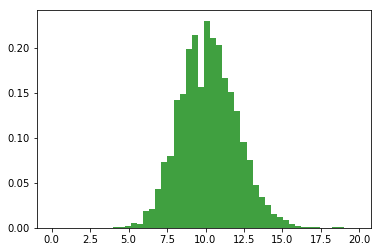

In [166]:
# plot distribution of random word pair distances
n, bins, patches = plt.hist([random_distances], 50, normed=1, facecolor='green', alpha=0.75)

In [189]:
print(token_dict['a'])
print(token_dict['to'])
print(token_dict['ne'])
print(token_dict['yþa'])
print(token_dict['ea'])
print(token_dict['east'])
print(token_dict['land'])
print(token_dict['um'])

207
1813
1868
22
7
9
69
1


In [ ]:
# cpnd_token = "eastlandum"
# for i in range(len(cpnd_token)):
#     vowel_groups = 0
#     c = cpnd_token[i]
#     print(c)
#     candidate_split = 0
#     if c in vowels:
#         if i==0:
#             vowel_groups += 1
#         elif cpnd_token[i-1] in consonants:
#             vowel_groups += 1
#         if cpnd_token[i+1] in consonants:
#             candidate_split = 1 
#     elif c in consonants:
        
    